In [1]:
%load_ext autoreload
%autoreload 2
from utils_dir import *
include_home_dir()


from jumpmodels.utils import *                        # useful helpers
from jumpmodels.jump import JumpModel                 # class of JM & CJM
from jumpmodels.sparse_jump import SparseJumpModel    # class of Sparse JM

# Load Data & Features

In this example, we will analyze the regimes of the Nasdaq-100 Index. The price index data is retrieved from [Yahoo Finance](https://finance.yahoo.com/quote/%5ENDX/) under the ticker `NDX`. The data retrievel is completed in the script `get_data.py` and the data have already been saved in the folder `example/Nasdaq/data/` in both `csv` and `pkl` forms, so you don't need to run `get_data.py` manually.


We need to feed a good feature set into the jump models, which is the key to successful applications of all learning algorithms. Many literature presented in `README.md` provides a solid foundation for exploration. In this example we work on a feature of nine features in total, representing the exponentially weighted moving (EWM) return, downside deviation (in logscale) and Sortino ratio, under three values of the halflife ranging from a week (5 days) to  a quarter (3 months). Users need to adapt the feautres for different applications.


The details on how to compute them are included in `feature.py`, and we encapsulate the loading of both index returns and features into a class `DataLoader`. We load the data during the time span from start of 2005 to the end of Sept of 2024.

In [36]:
from feature import DataLoader

data = DataLoader(ticker="NDX", ver="v0").load(start_date="2005-1-1", end_date="2024-09-30")

In [3]:
from jumpmodels.plot import plot_cumret

<Axes: ylabel='Cumulative Returns'>

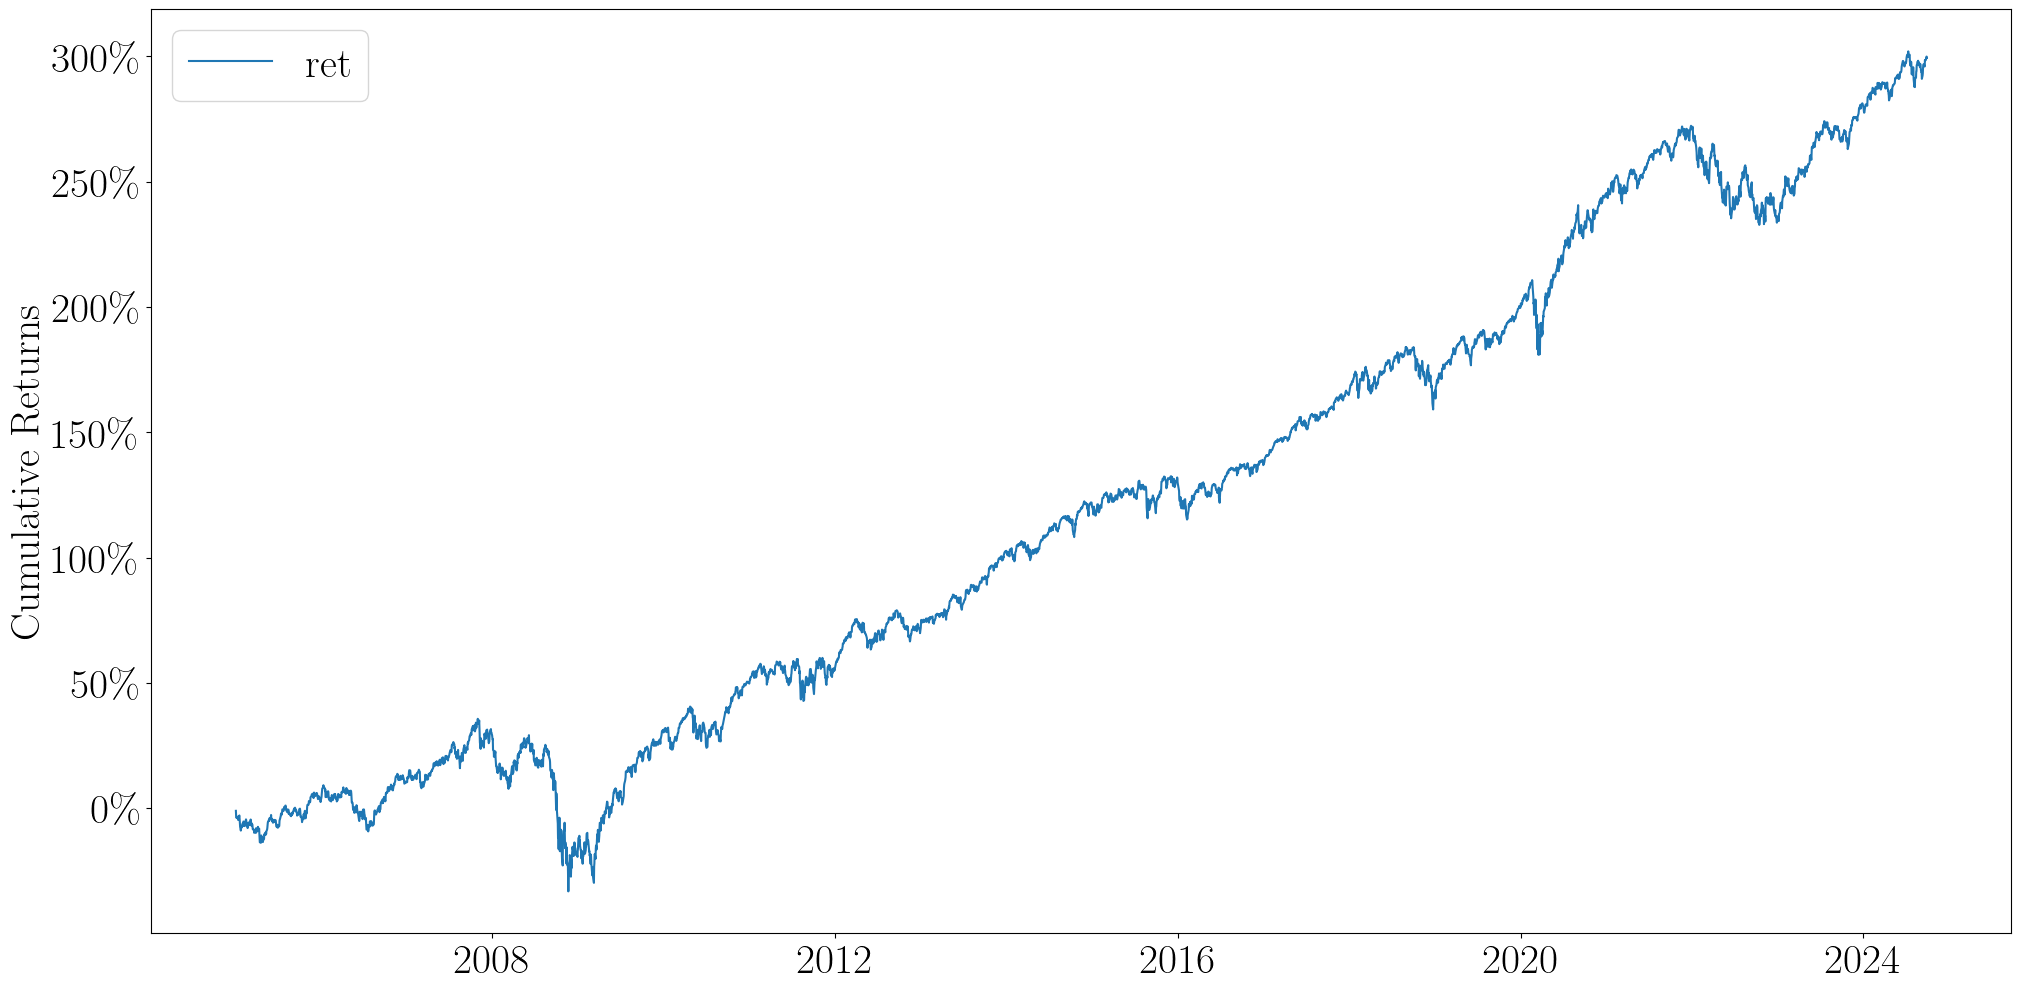

In [4]:
plot_cumret(data.ret_ser)

In [5]:
train_start, test_start = "2007-1-1", "2022-1-1"

In [6]:
X_train = filter_date_range(data.X, train_start, test_start)
X_test = filter_date_range(data.X, test_start)

In [7]:
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()

In [8]:
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))

In [21]:
jm = JumpModel(jump_penalty=50.,)
cjm = JumpModel(jump_penalty=200., cont=True)

In [22]:
jm.fit(X_train_processed, ret_ser=data.ret_ser)

JumpModel(jump_penalty=50.0)

In [24]:
jm.ret_*252

array([ 0.28085225, -0.27189687])

In [25]:
cjm.fit(X_train_processed, ret_ser=data.ret_ser)

JumpModel(cont=True, jump_penalty=200.0)

In [27]:
cjm.ret_*252

array([ 0.29958214, -0.18717001])

In [11]:
from jumpmodels.plot import *

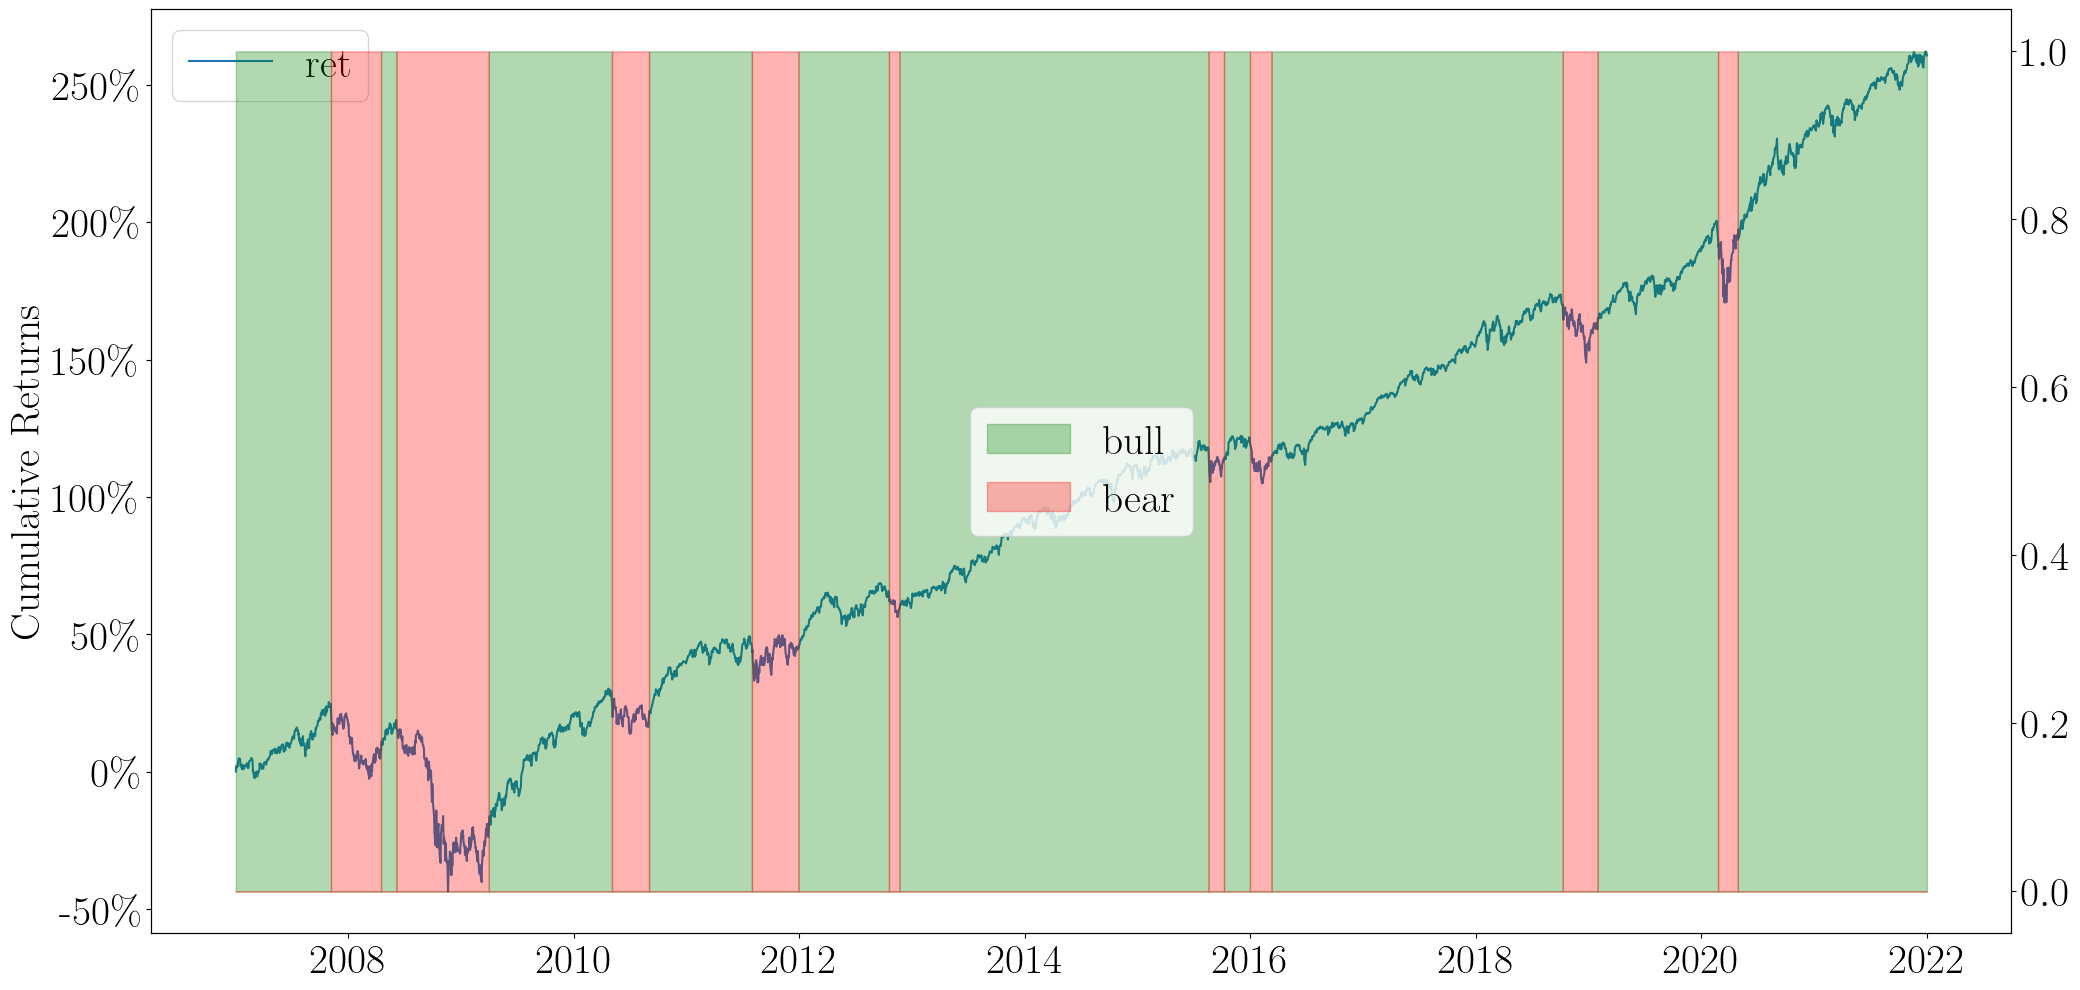

In [14]:
plot_regimes_and_cumret(jm.labels_, data.ret_ser, start_date=jm.labels_.index[0], end_date=jm.labels_.index[-1], )

(<Axes: ylabel='Cumulative Returns'>, <Axes: >)

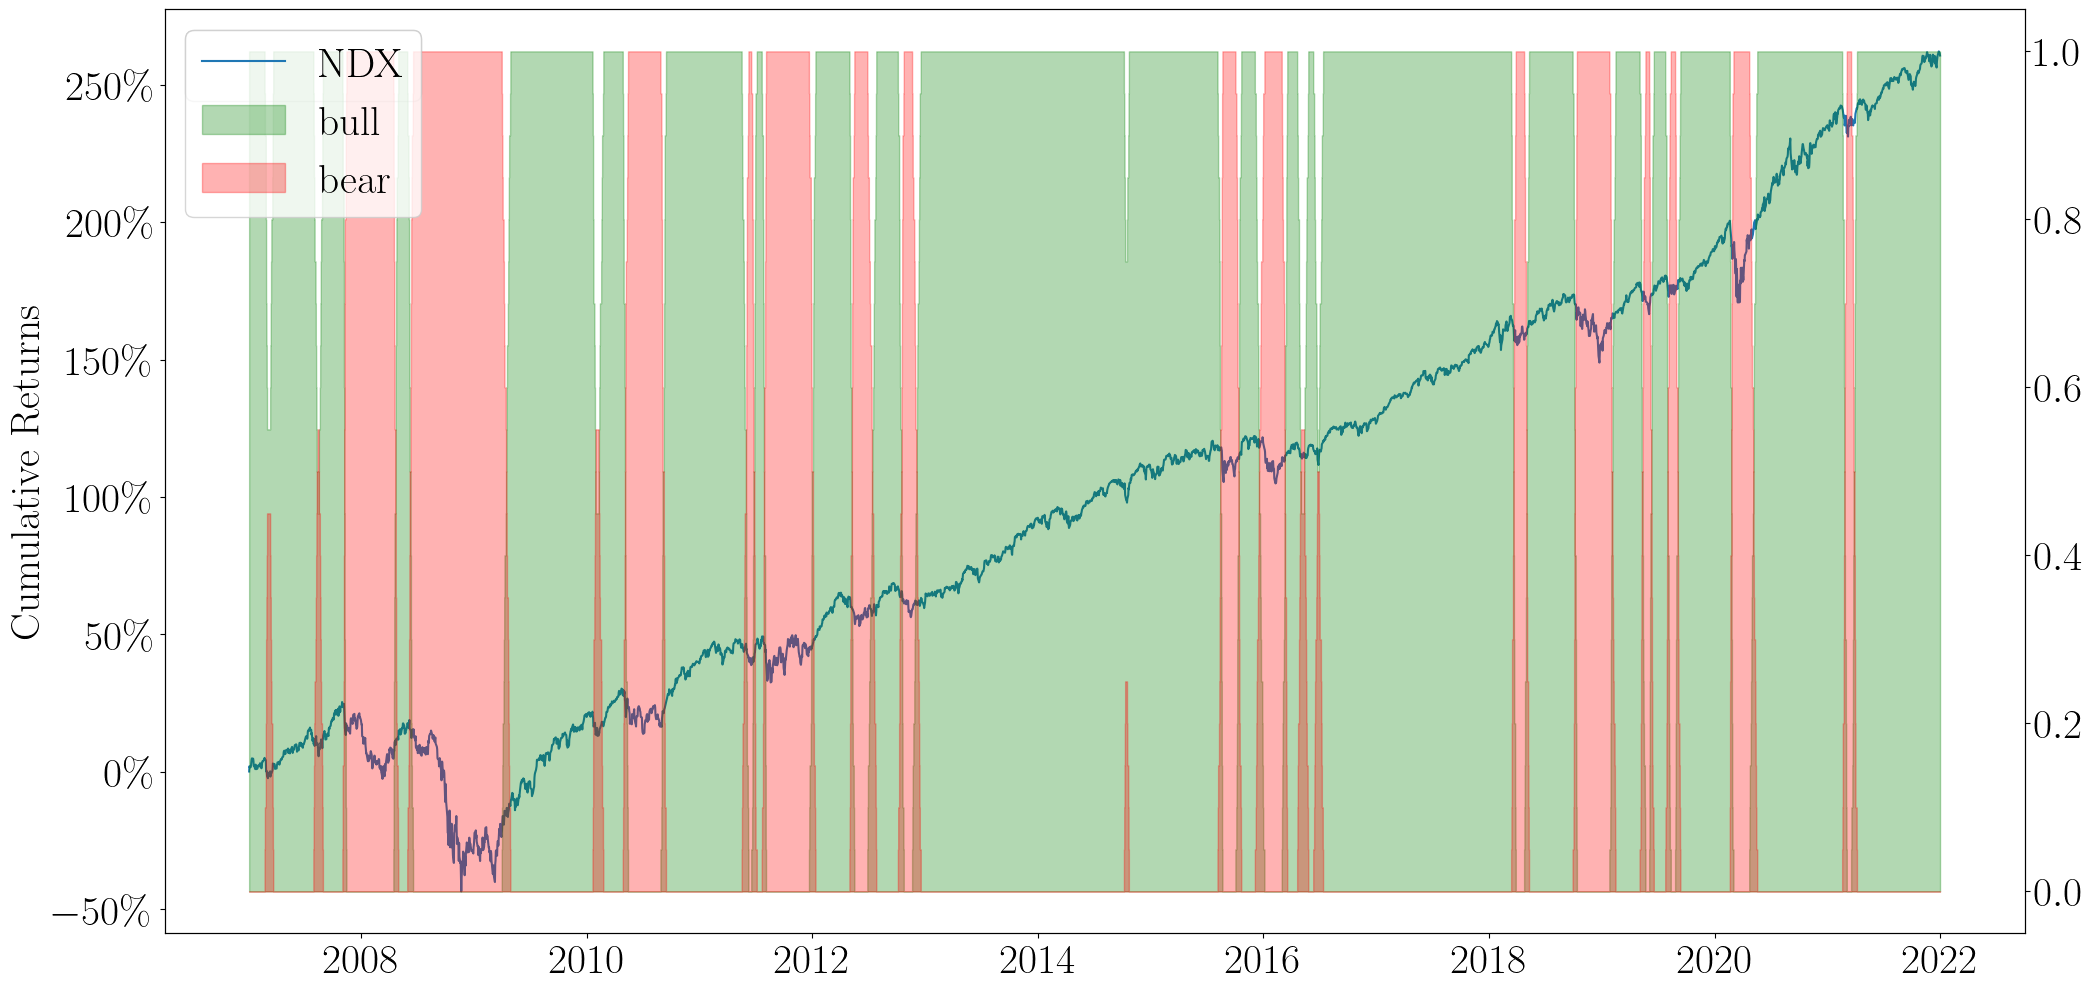

In [37]:
plot_regimes_and_cumret(cjm.proba_, data.ret_ser, start_date=jm.labels_.index[0], end_date=jm.labels_.index[-1], )

In [15]:
labels_test = jm.predict_online(scalar.transform(clipper.transform(X_test)))

(<Axes: ylabel='Cumulative Returns'>, <Axes: >)

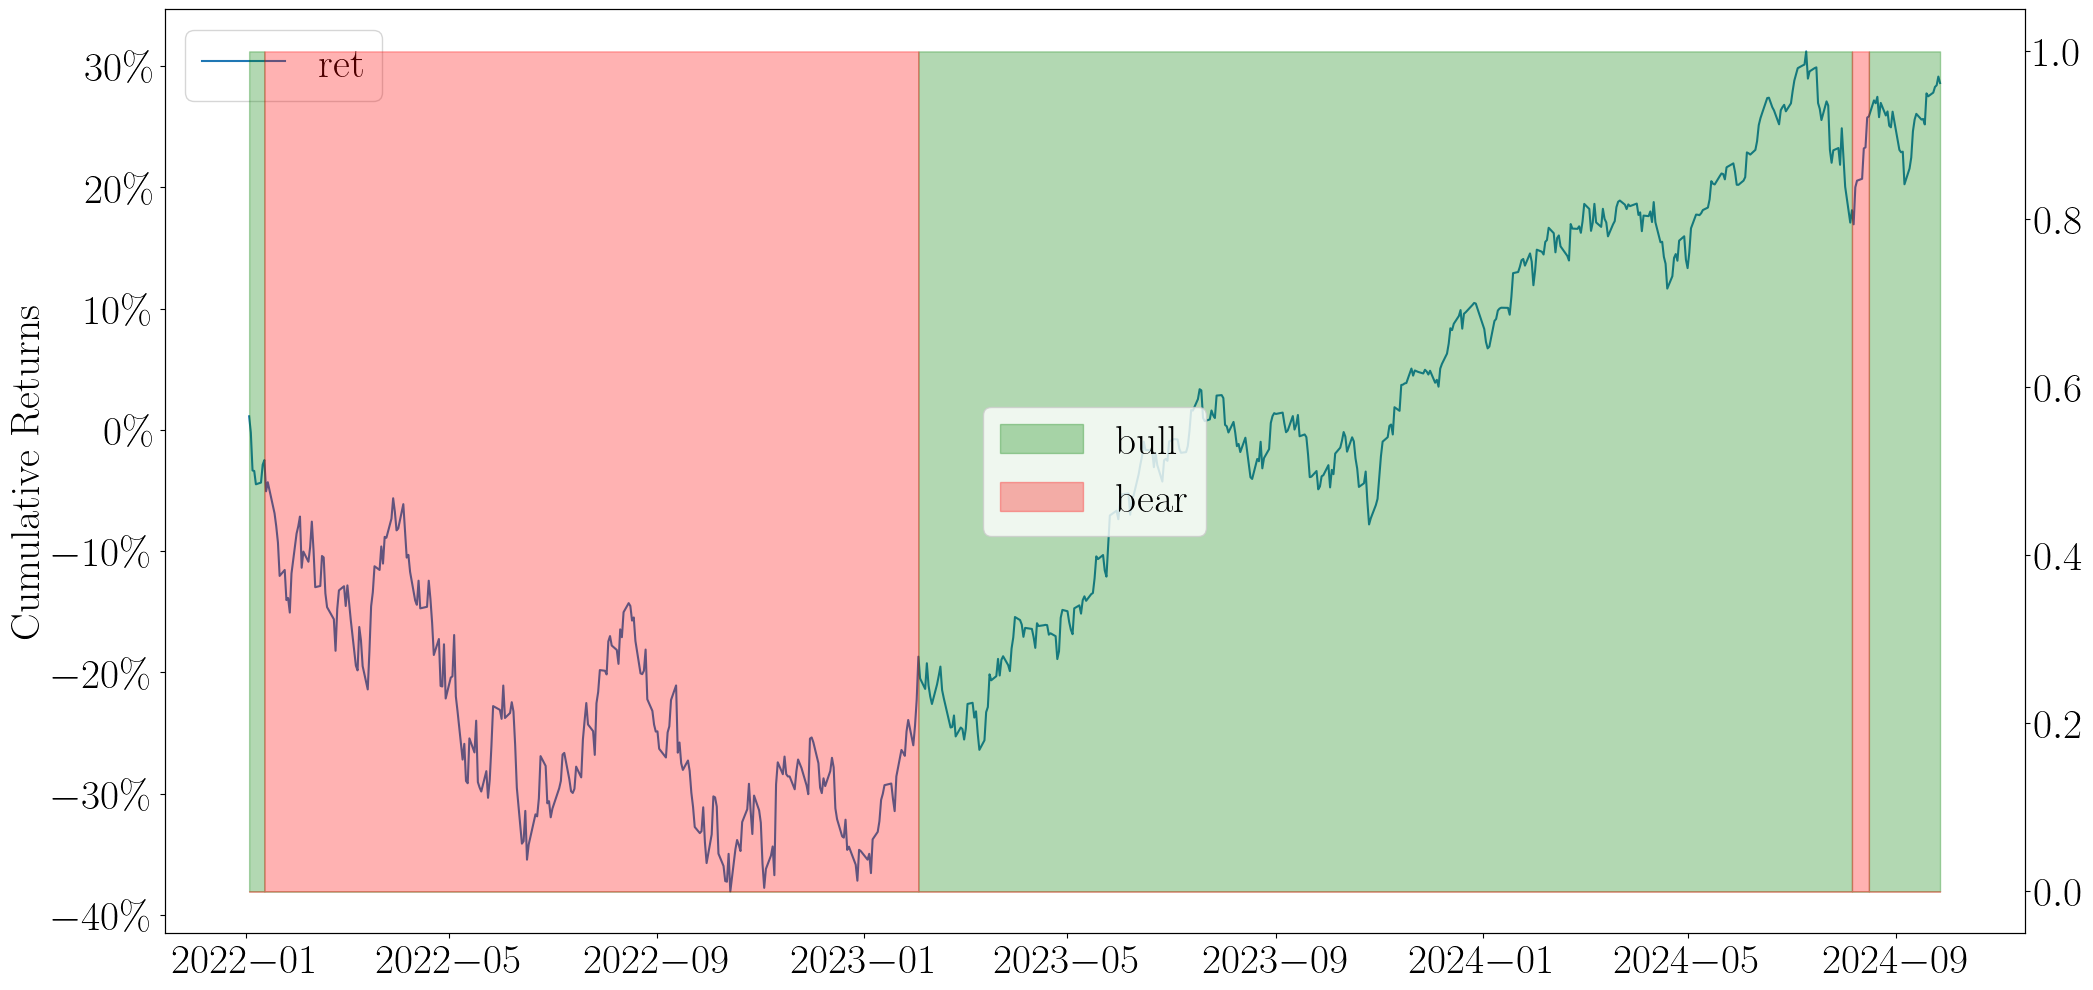

In [20]:
plot_regimes_and_cumret(labels_test, data.ret_ser, start_date=labels_test.index[0], end_date=labels_test.index[-1], )

In [ ]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [40]:
plt.rcParams['axes.prop_cycle'].by_key()['color']

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [4]:
data.ret_ser

date
2005-01-03   -0.010863
2005-01-04   -0.019757
2005-01-05   -0.005134
2005-01-06   -0.003990
2005-01-07    0.004681
                ...   
2024-09-23    0.003067
2024-09-24    0.004667
2024-09-25    0.001392
2024-09-26    0.007156
2024-09-27   -0.005315
Name: ret, Length: 4968, dtype: float64

In [ ]:
df = pd.read_pickle("data.pkl")
ret = df.ret
X = load_example_features(ret)
print(df.tail())
print(X.tail())

In [3]:
START, END = "1990-1-1", "2002-1-1"
X_train = filter_date_range(X, START, END)
ret_ser_train = filter_date_range(ret, START, END)
scaler = StandardScaler()
X_train_standard = raise_arr_to_pd_obj(scaler.fit_transform(X_train), X_train, columns_key="columns", return_as_ser=False)

# Baseline Methods

For comparison, we initially fit the data using a baseline model, which is the $k$-means clustering. It's important to note that the fitted regimes lack persistence and exhibit numerous jumps.

In [4]:
kmeans = KMeans(3, n_init=10, tol=1e-8, max_iter=1000, random_state=RANDOM_STATE+1)
kmeans.fit(X_train_standard)

KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=1, tol=1e-08)

<Axes: title={'center': '$k$-means Clustering Regime Labels, # of regime shifts: 103'}, ylabel='regime'>

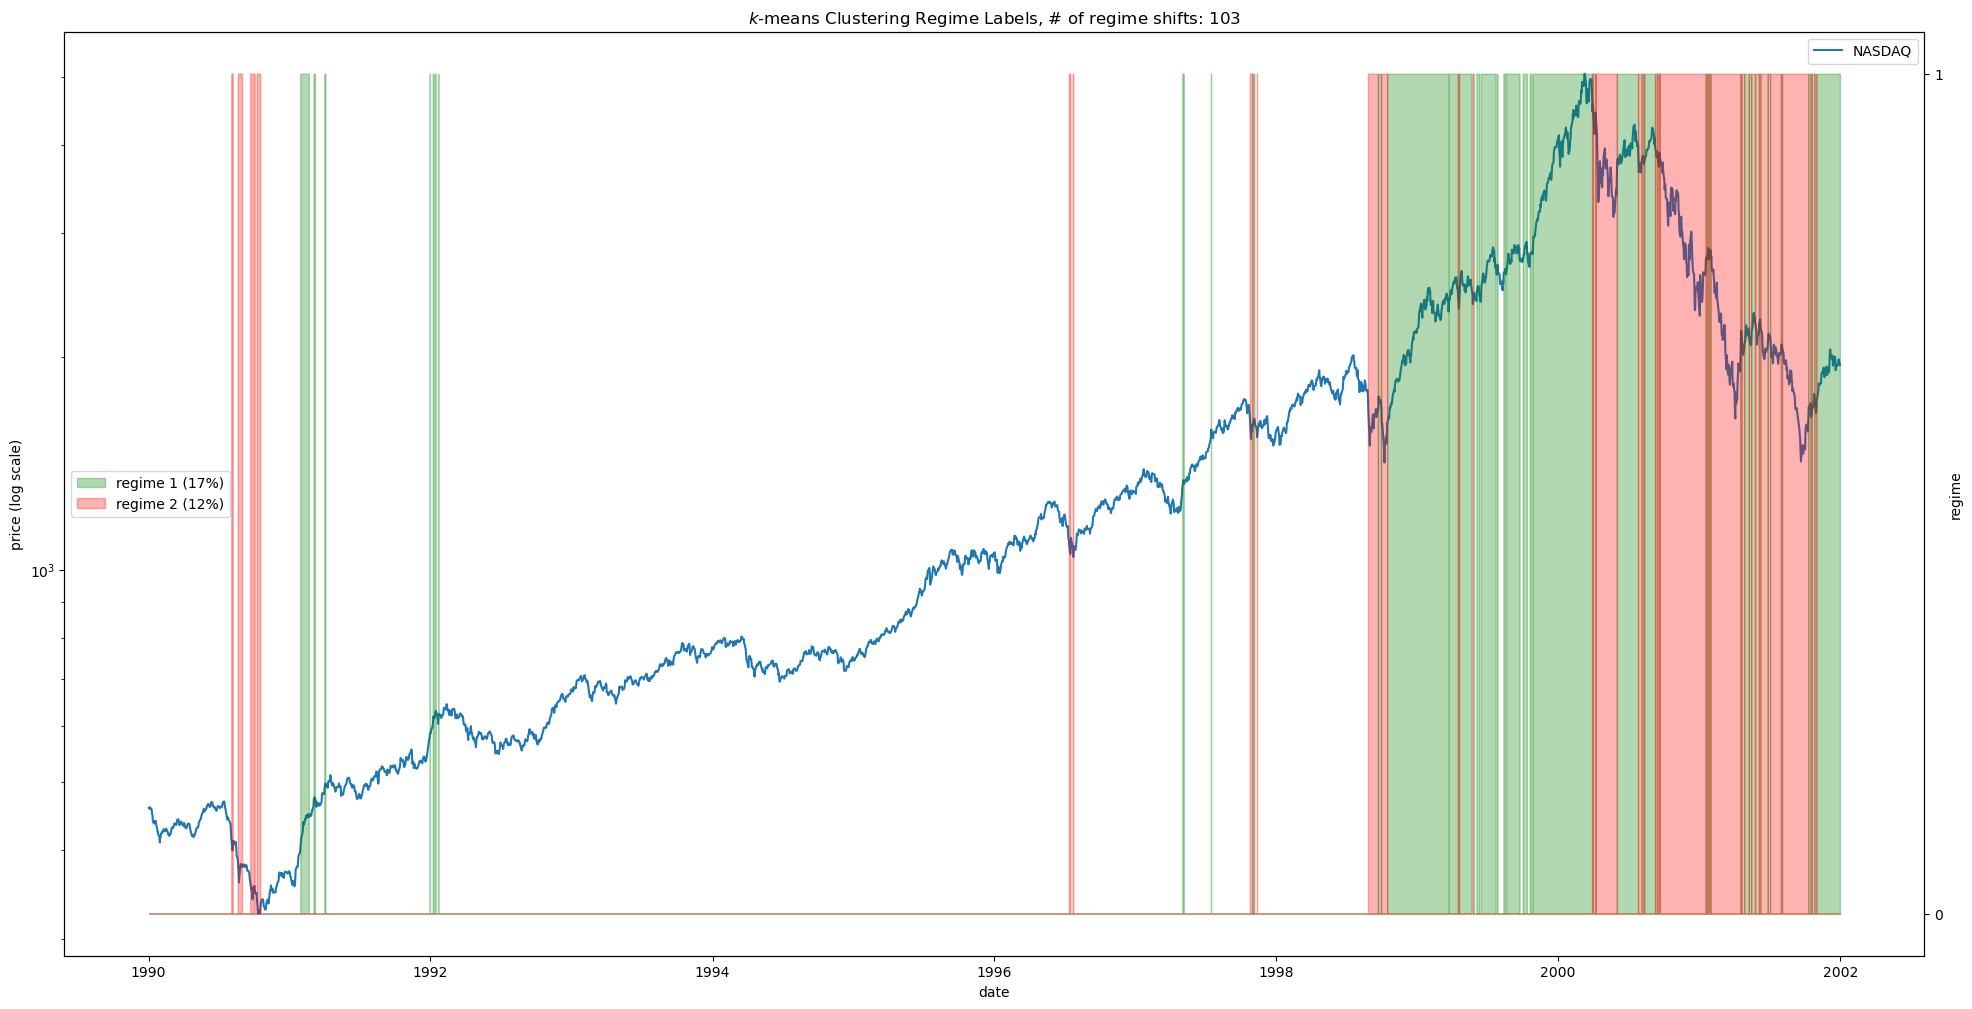

In [5]:
ax=check_axes()
filter_date_range(pd.DataFrame({"NASDAQ": df.prc}), START, END).plot(ax=ax)
ax.set(ylabel="price (log scale)", yscale="log")
ax2 = ax.twinx()
plot_regime(raise_arr_to_pd_obj(kmeans.labels_, ret_ser_train), ax=ax2, title=r"$k$-means Clustering Regime Labels")

# In-sample Fitting of JMs & CJMs

Subsequently, we fit the Jump Models (JMs) and Composite Jump Models (CJMs) in-sample. It's worth mentioning that the jump penalty inputted here is somewhat arbitrary and serves solely for illustrative purposes. This crucial hyperparameter controls the desired level of persistence and is recommended to be chosen in a train-validation-test cross-validation setting, tailored to downstream applications such as portfolio construction.

Despite the challenge of selecting the jump penalty, we observe a significant improvement in the persistence of the inferred regime sequence.

In [6]:
# discrete JM
jm = JumpModel(3, 1e2, random_state=RANDOM_STATE).fit(X_train_standard, ret_ser_train, sort_by="vol")
# CJM w/ mode loss
cjm_mode = JumpModel(3, 1e3, cont=True, random_state=RANDOM_STATE, verbose=True).fit(X_train_standard, ret_ser_train, sort_by="vol")
# CJM w/o mode loss
cjm_no_mode = JumpModel(3, 1e3, cont=True, mode_loss=False, random_state=RANDOM_STATE, verbose=True).fit(X_train_standard, ret_ser_train, sort_by="vol")

0-th init. val: 4496.373961135983
1-th init. val: 4496.373961135983
2-th init. val: 5244.197181383882
3-th init. val: 4496.373961135983
4-th init. val: 4496.373961135983
5-th init. val: 4493.919737694364
6-th init. val: 5244.197181383882
7-th init. val: 4496.373961135983
8-th init. val: 4496.373961135983
9-th init. val: 5244.197181383882
5-th init has the best value: 4493.919737694364.
0-th init. val: 4481.322188396539
1-th init. val: 4481.322188396539
2-th init. val: 5226.66455165435
3-th init. val: 4481.322188396539
4-th init. val: 4481.322188396539
5-th init. val: 4483.885222534729
6-th init. val: 5226.66455165435
7-th init. val: 4481.322188396539
8-th init. val: 4481.322188396539
9-th init. val: 5226.66455165435
0-th init has the best value: 4481.322188396539.


<Axes: title={'center': 'CJM (with mode loss)-inferred Regime Probabilites, $\\lambda$=1000.0, # of regime shifts: 4'}, ylabel='regime'>

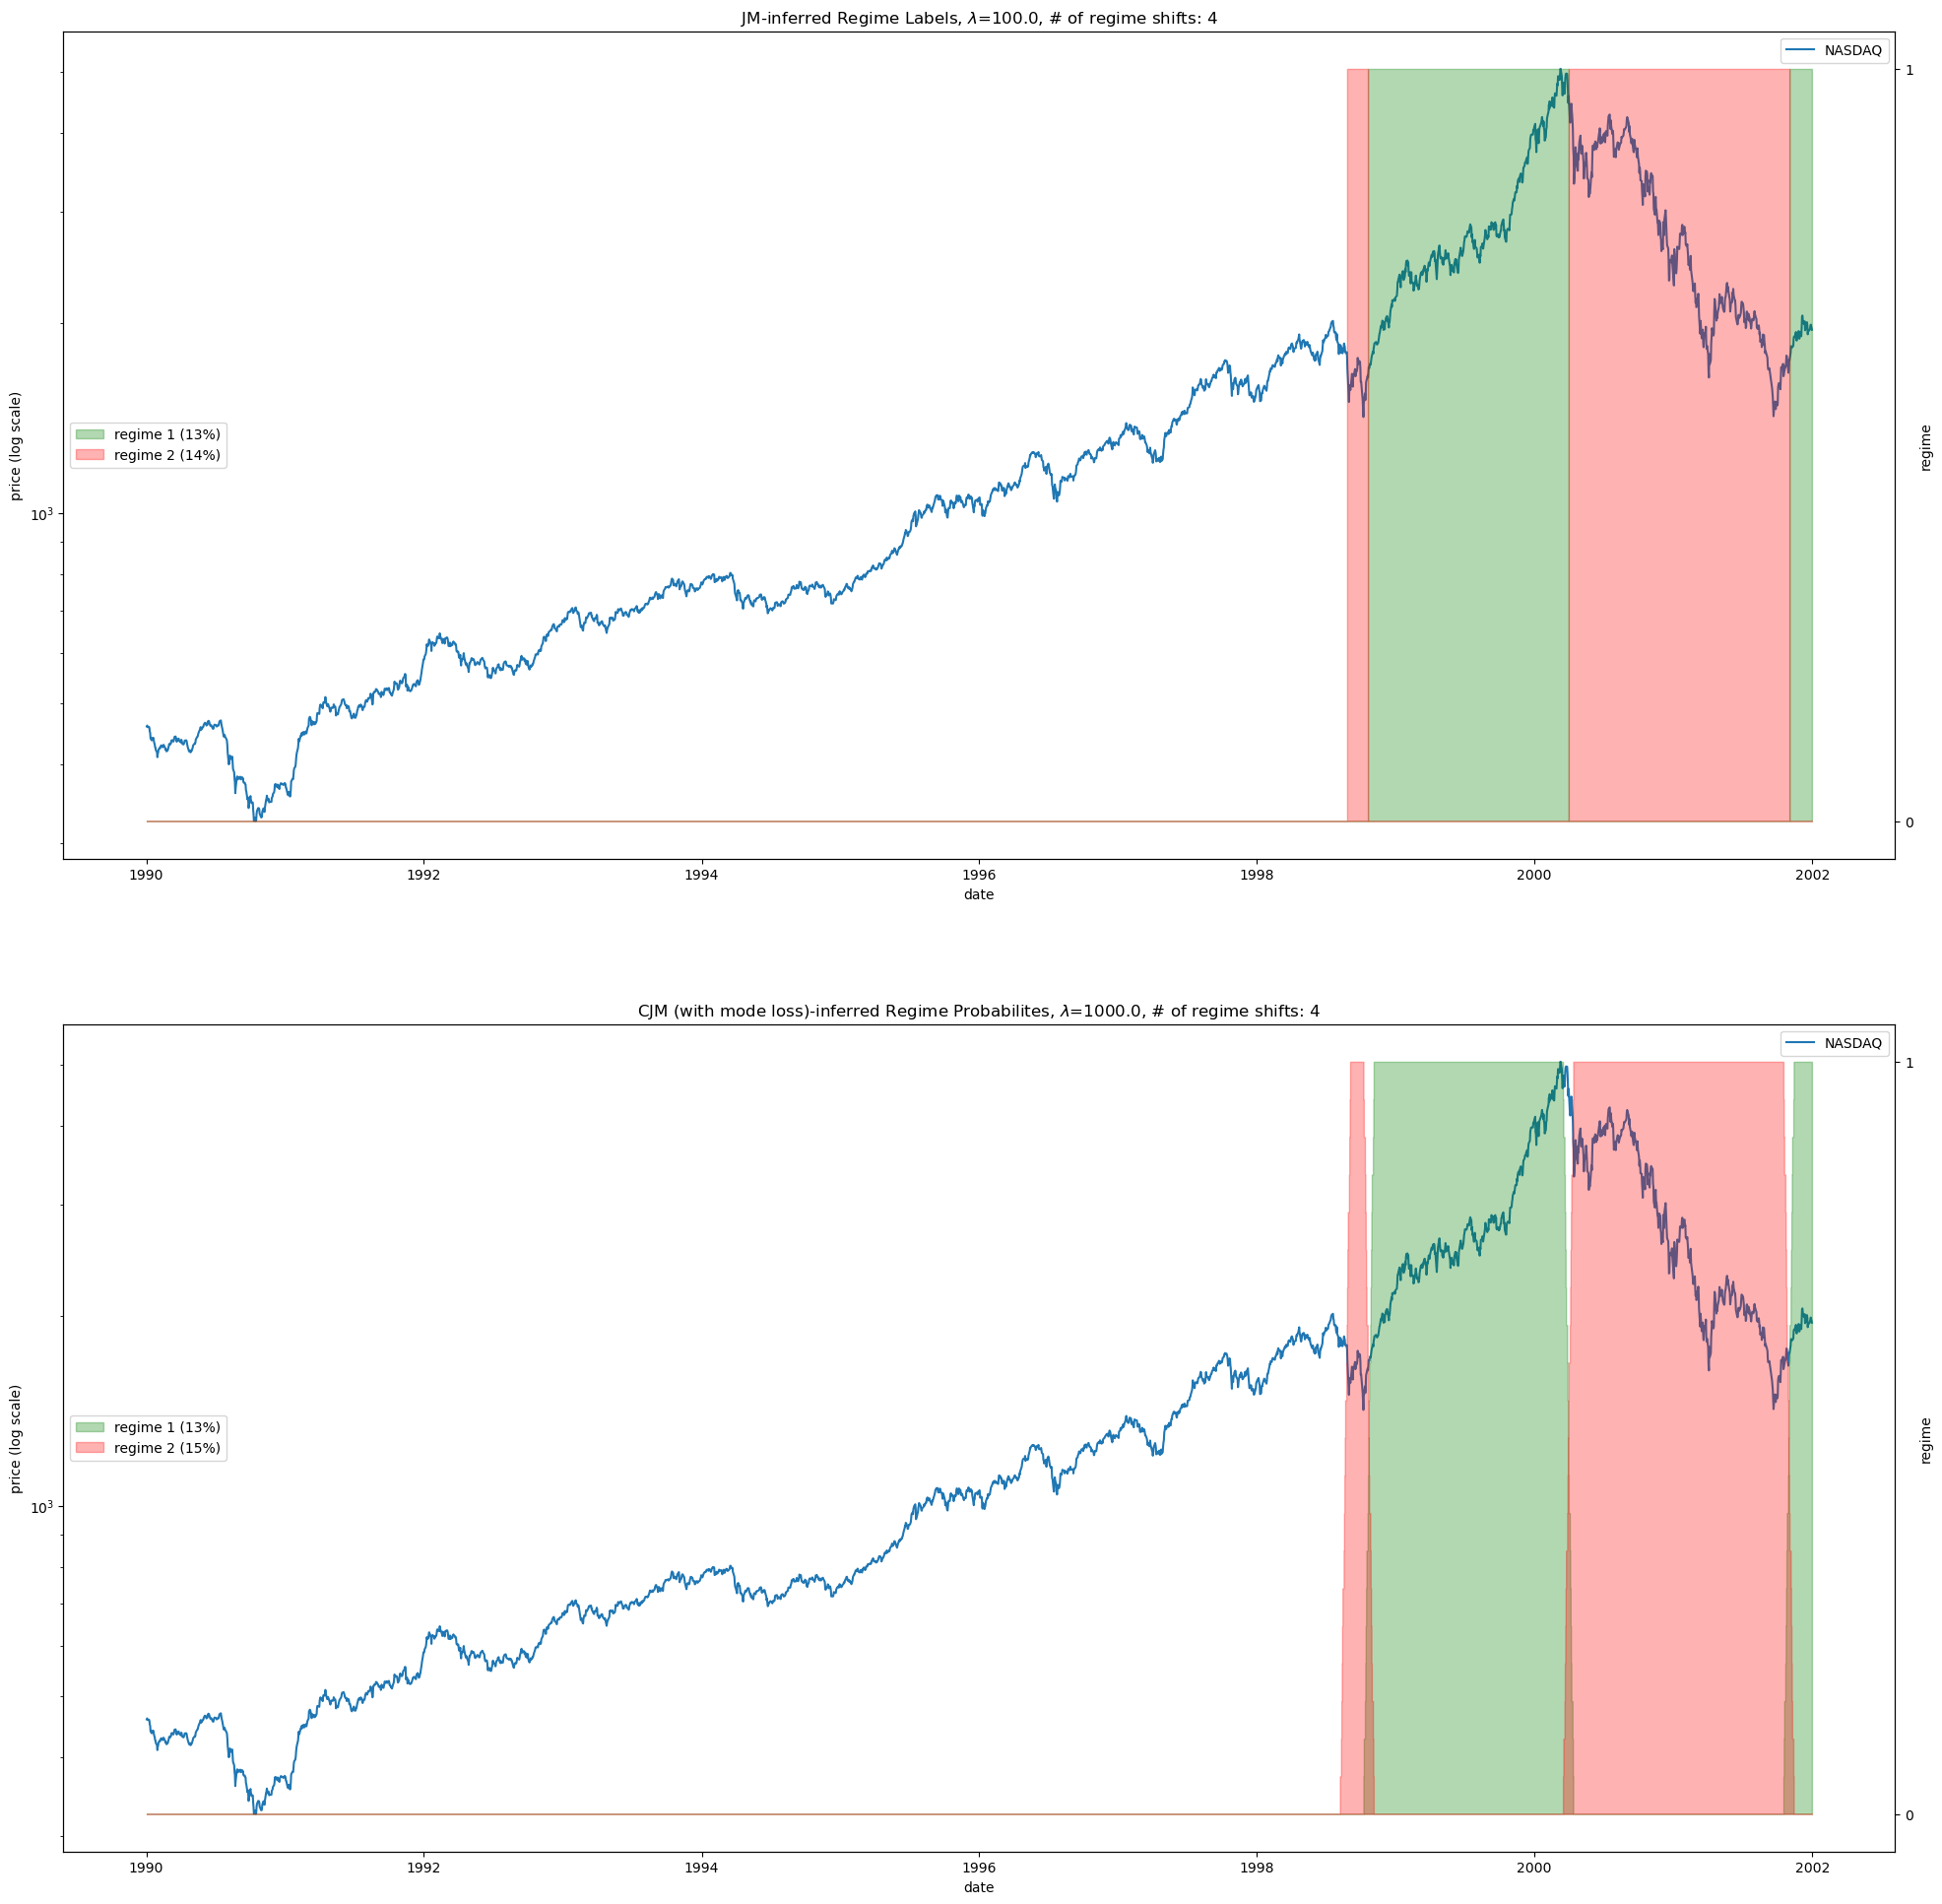

In [7]:
ax = check_axes(nrows=2)
i=0
filter_date_range(pd.DataFrame({"NASDAQ": df.prc}), START, END).plot(ax=ax[i])
ax[i].set(ylabel="price (log scale)")
ax2 = ax[i].twinx()
plot_regime(jm.labels_, ax=ax2, title=r"JM-inferred Regime Labels, $\lambda$=100.0")
ax[i].set(yscale="log")
i=1
filter_date_range(pd.DataFrame({"NASDAQ": df.prc}), START, END).plot(ax=ax[i])
ax[i].set(ylabel="price (log scale)", yscale="log")
ax2 = ax[i].twinx()
plot_regime(cjm_mode.proba_, ax=ax2, title=r"CJM (with mode loss)-inferred Regime Probabilites, $\lambda$=1000.0")

# Out-of-sample Fitting

Lastly, we demonstrate how to perform out-of-sample prediction using jump models. It's worth noting that the in-sample and out-of-sample jump penalty may differ. We reiterate the importance of prudent and meticulous tuning of these hyperparameters.

The usefulness of the out-of-sample clustering results depends largely on how they are applied to downstream trading applications.

In [8]:
END = "2022-1-1"
X_train = filter_date_range(X, START, END)
ret_ser_train = filter_date_range(ret, START, END)
scaler = StandardScaler()
X_train_standard = raise_arr_to_pd_obj(scaler.fit_transform(X_train), X_train, columns_key="columns", return_as_ser=False)
X_test = filter_date_range(X, start_date="2020-1-1")
X_test_standard = raise_arr_to_pd_obj(scaler.transform(X_test), X_test, columns_key="columns", return_as_ser=False)

In [9]:
jm.fit(X_train_standard, ret_ser_train, sort_by="vol")

JumpModel(jump_penalty=100.0, n_components=3, random_state=0)

In [10]:
# set oos lambd
jm.set_params(jump_penalty=50.0).check_jump_penalty_mx()

array([[ 0., 50., 50.],
       [50.,  0., 50.],
       [50., 50.,  0.]])

In [11]:
labels_oos_jm = filter_date_range(jm.predict_proba_online(X_test_standard).shift(), start_date=END)

<Axes: title={'center': 'JM-inferred Out-of-sample Regime Probabilites, $\\lambda_{\\text{is}}$=100.0, $\\lambda_{\\text{oos}}$=50.0, # of regime shifts: 5'}, ylabel='regime'>

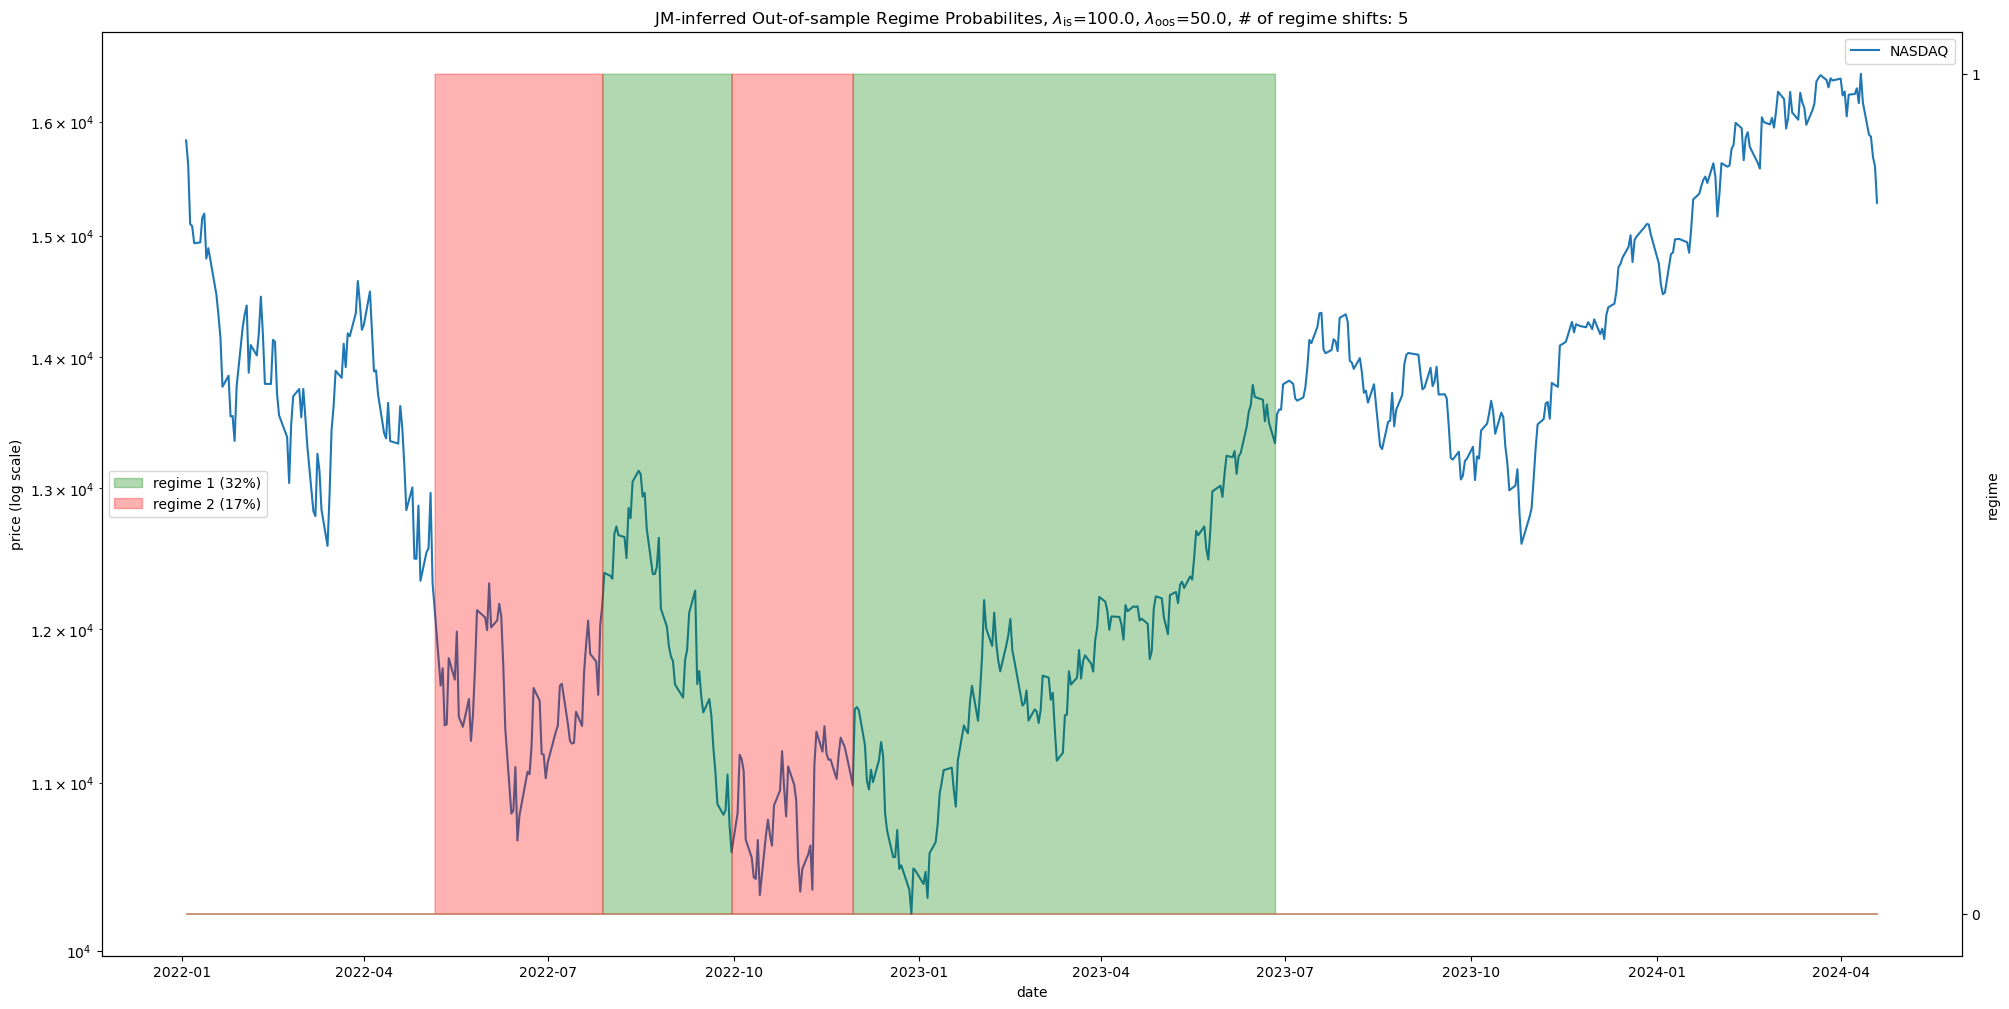

In [12]:
ax = check_axes()
filter_date_range(pd.DataFrame({"NASDAQ": df.prc}), END).plot(ax=ax)
ax.set(ylabel="price (log scale)", yscale="log")
ax2 = ax.twinx()
plot_regime(labels_oos_jm, ax=ax2, title=r"JM-inferred Out-of-sample Regime Probabilites, $\lambda_{\text{is}}$=100.0, $\lambda_{\text{oos}}$=50.0")